<a href="https://colab.research.google.com/github/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_(oxford_iiit_pet_dataset)_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmentation with U-Net

This notebook contains an implementation of:

* **Algorithm**: Ronneberger et al., U-Net Convolutional Networks for Biomedical Image Segmentation
* **Dataset**: [oxford iiit pet dataset](https://www.kaggle.com/tanlikesmath/the-oxfordiiit-pet-dataset) (published by Kaggle)
* **Packages Used**:

### Before We Code...
**Some Additional Context**: Convolutional Neural Networks have allowed ML enthusiasts to innovate on applications which were once considered computational torment. Today, the innovation of ConvNets are a part of our lives via various applications like Medical Image Computing, Self Driving Cars, and so on. The popular applications usually uses ConvNets for the following purposes -
* Image Classification: Identifying if an image has an item(s) or not
* Object Localization: Locating the classified item in the image
* Object Dectection (using Bounding Box): Detecting multiple objects in a picture along with their classes
* Image Segmentation: Detecting objects by predicting a label for each pixel in the image
<br>
<br>
<div>
<center>
<img src="https://miro.medium.com/max/1600/1*SNvD04dEFIDwNAqSXLQC_g.jpeg" alt="Figure 1" width="600" height="350"/>
<caption> <br><u><b>Figure 1</u></b>: Applications of ConvNets <br><i>(source: Detection and Segmentation through ConvNets, towards data science, Medium)</i> <br> </caption>
</center>
</div>
<br>

### ... And what is U-Net?
U-Net is one of the most popular architectures for Image Segmentation. It was introduced by Olaf Ronneberger, Philipp Fischer, Thomas Brox in 2015 for tumor detection but since has been found to be useful across multiple industries.
<br>
<br>
<div>
<center>
<img src="https://miro.medium.com/max/4080/1*wninXztJ90h3ZHtKXCNKFA.jpeg" alt="Figure 2" width="400" height="200"/>
<caption> <br><u><b>Figure 2</u></b>: Here's how a self driving car sees the world through Image Segmentation <br><i>(source: Intro to Artificial Intelligence, Medium)</i> <br> </caption>
</center>
</div>
<br>


### What's so different about U-Net? 

To allocate a class to each pixel in an image, Image Segmentation requires the downscaled image due to convolution (explained in 'Encoder block' below) to be upscaled to a size closer to the original image. Architectures before U-Net used Dense Layers to upscale images which made them computationally expensive. They also suffered from information loss due to traversal of images across multiple layers. U-Net solves for this by -
* **Upscales images** back to original input size using **transposed convolutions** (explained in 'Decoder Block' below)
* **Retains spatial information** which usually would get lost in multiple  ConvNets by using **skip connections** (also explained in 'Decoder Block' below)
</font>


<div>
<center>
<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" alt="Figure 3" width="600" height="400"/>
<caption> <br><u><b>Figure 3</u></b>: U-Net gets its name from its 'U'-like shape <br><i>(source: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)</i> <br> </caption>
</center>
</div>
<br>




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Code Breakdown

- [1 - Packages](#1)
- [2 - Helper Functions for Data Processing](#2)
    - [2.1 - Load Data](#2.1)
    - [2.2 - Pre-Process Data](#2.2)
- [3 - Constructing the U-Net Architecture](#3)
    - [3.1 - U-Net Encoder Block](#3.1)
    - [3.2 - U-Net Decoder Block](#3.2)
    - [3.3 - Compile U-Net Blocks](#3.3)
- [4 - Main Function for Training Model](#4)
    - [4.1 - Load and View Data](#4.1)
    - [4.2 - Process Data](#4.2)
    - [4.3 - Split Train and Test](#4.3)
    - [4.4 - Build U-Net Arch. for Data Dims](#4.4)
    - [4.5 - Compile and Run Model](#4.5)
- [5 - Evaluate Results](#5)
    - [5.1 - Bias-Variance Check](#5.1)
    - [5.2 - View Predicted Segmentations](#5.2)
    - [5.3 - Some Techniques to Improve Results](#5.3)
- [6 - Final Accuracy with Test Set](#6)
- [7 - Saving the Optimized Parameters](#7)


<a name='1'></a>
## 1 - Packages

In [ ]:
import os               # for data load
import imageio          # for reading images
import matplotlib.pyplot as plt # for visualization of images
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

<a name='2'></a>
# 2 - Helper Functions for Data Processing

<a name='2.1'></a>
## 2.1 - Load Data
* the masked images are stored as png, unmasked (original) as jpg
* the names of these 2 are same so for getting the right sample we can just sort the 2 lists

In [ ]:
def LoadData (path1, path2):
    """
    Loads original and masked files from the path and index shared
    Returns list of original and masked files
    
    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)

    # Split data into masked and unmasked images
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)

    # Sort the lists to get both of them in same order
    orig_img.sort()
    mask_img.sort()
    
    return orig_img, mask_img

<a name='2.2'></a>
## 2.2 - Pre-Process Data

In [ ]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask
    
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    
    # Pull the relevant dimensions for image and mask
    
    # Define X and Y as number of images, shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    
    # Resize images and masks
    for file in img:
        # images
        index = img.index(file)
        path = os.path.join(path1, file)
        single_img = Image.open(path).convert('RGB')
        single_img = single_img.resize((i_h,i_w))
        single_img = np.reshape(single_img,(i_h,i_w,i_c)) 
        single_img = single_img/256.
        X[index] = single_img
        
        # masks
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = Image.open(path)
        single_mask = single_mask.resize((m_h, m_w))
        single_mask = np.reshape(single_mask,(m_h,m_w,m_c)) 
        single_mask = single_mask - 1
        # single_mask = single_mask / 256.
        # single_mask = (single_mask!=2)*1.0
        # single_mask = 1.0*(single_mask[:,:,0]>0.2) 
        # print(single_mask.shape)
        y[index] = single_mask
    return X, y

<a name='3'></a>
#3 - Constructing the U-Net Architecture

2 parts ....

add a pic and give brief explaination


conv block contains 2 conv blocks ,

<a name='3.1'></a>
## 3.1 - U-Net Encoder Block

In [ ]:
def EncoderMiniBlock(inputs=None, n_filters=64, dropout_prob=0, max_pooling=True):
    """
    explain a bit here
    
    """
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)
    conv = BatchNormalization()(conv, training=False)
    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv
    
        
    skip_connection = conv
    
    return next_layer, skip_connection

<a name='3.2'></a>
## 3.2 - U-Net Decoder Block

In [ ]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=64):
    """
    
    """
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)
    
    merge = concatenate([up, skip_layer_input], axis=3)
    
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

#TensorShape([None, 28, 28, 1024]) 5
#[None, 64, 64, 512] #4

<a name='3.3'></a>
## 3.3 - Compile U-Net Blocks

add some deets


In [ ]:

def UNetCompiled(input_size=(572, 572, 3), n_filters=16, n_classes=3):
   
    inputs = Input(input_size)
    
    # Encoder Layers
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder Layers
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='4'></a>
# 4 - Main Function for Training

<a name='4.1'></a>
## 4.1 - Load and View Data

(400, 600, 3)
(400, 600)


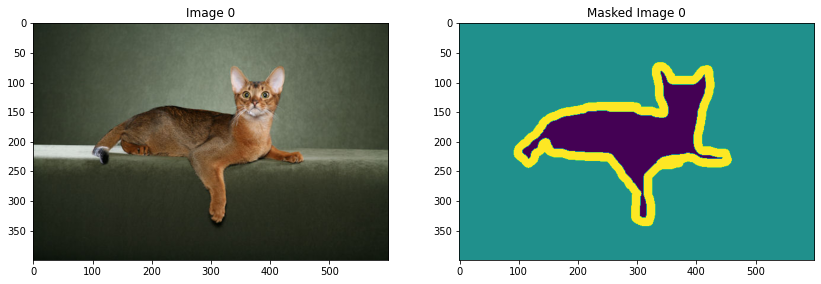

In [ ]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = '/content/drive/My Drive/U-NET - Cat Data and Code/images/original/'
path2 = '/content/drive/My Drive/U-NET - Cat Data and Code/images/masks/'
img, mask = LoadData (path1, path2)

# View an example of image and corresponding mask 
show_images = 1
for i in range(show_images):
    img_view  = imageio.imread(path1 + img[i])
    mask_view = imageio.imread(path2 + mask[i])
    print(img_view.shape)
    print(mask_view.shape)
    fig, arr = plt.subplots(1, 2, figsize=(14, 10))
    arr[0].imshow(img_view)
    arr[0].set_title('Image '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Masked Image '+ str(i))

<a name='4.2'></a>
## 4.2 Process Data

X Shape: (1000, 128, 128, 3)
Y shape: (1000, 128, 128, 1)
[0 1 2]


Text(0.5, 1.0, 'Processed Masked Image ')

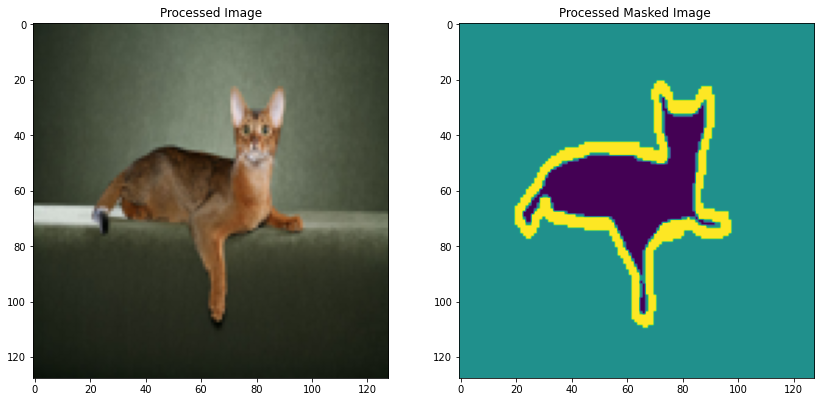

In [ ]:
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

X, y = PreprocessData(img[:1000], mask[:1000], target_shape_img, target_shape_mask, path1, path2)

print("X Shape:", X.shape)
print("Y shape:", y.shape)
print(np.unique(y))
# visualize the output
image_index = 0
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(X[image_index])
arr[0].set_title('Processed Image')
arr[1].imshow(y[image_index,:,:,0])
arr[1].set_title('Processed Masked Image ')

## 4.3 Split Train and Test Set

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=123)

# X_train.shape
# np.unique(y_train)

<a name='4.4'></a>
## 4.4 - Build U-Net Arch. for Data Dims

In [ ]:
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

<a name='4.5'></a>
## 4.5 Compile and Run Model

In [ ]:
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
27/27 [==============================] - 464s 17s/step - loss: 0.9496 - accuracy: 0.5685 - val_loss: 0.8808 - val_accuracy: 0.5954
Epoch 2/20
27/27 [==============================] - 452s 17s/step - loss: 0.8749 - accuracy: 0.5860 - val_loss: 0.7689 - val_accuracy: 0.6352
Epoch 3/20
27/27 [==============================] - 454s 17s/step - loss: 0.7485 - accuracy: 0.7026 - val_loss: 0.7021 - val_accuracy: 0.7127
Epoch 4/20
27/27 [==============================] - 452s 17s/step - loss: 0.6824 - accuracy: 0.7283 - val_loss: 0.6711 - val_accuracy: 0.7390
Epoch 5/20
27/27 [==============================] - 456s 17s/step - loss: 0.6232 - accuracy: 0.7523 - val_loss: 0.6485 - val_accuracy: 0.7291
Epoch 6/20
27/27 [==============================] - 459s 17s/step - loss: 0.5925 - accuracy: 0.7664 - val_loss: 0.5700 - val_accuracy: 0.7784
Epoch 7/20
27/27 [==============================] - 463s 17s/step - loss: 0.5615 - accuracy: 0.7796 - val_loss: 0.5815 - val_accuracy: 0.7693
Epoch 

add screenshot of above results

<a name='5'></a>
# 5 - Evaluate Model Results

<a name='5.1'></a>
## 5.1 - Bias Variance Check

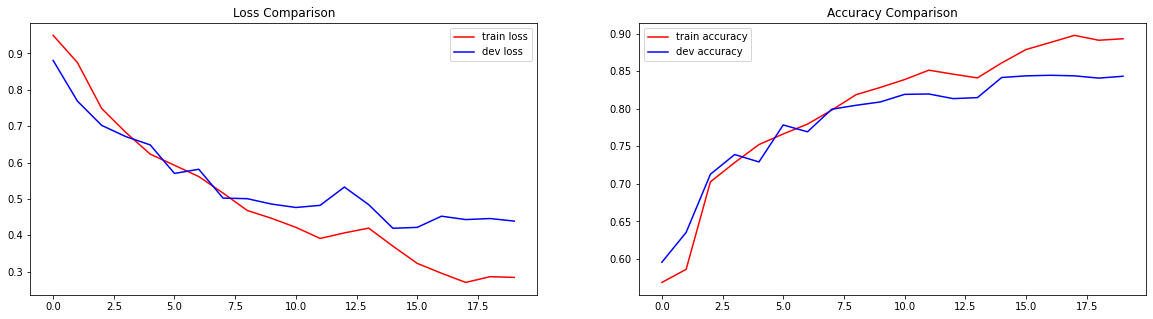

In [ ]:
#plot a bias - variance graph
# results.history.keys()
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

<a name='5.2'></a>
## 5.2 - Viewing Predicted Segmentations

In [ ]:
unet.evaluate(X_valid, y_valid)

In [ ]:
def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    pred_mask = create_mask(pred_y)
    fig, arr = plt.subplots(1, 3, figsize=(14, 7))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

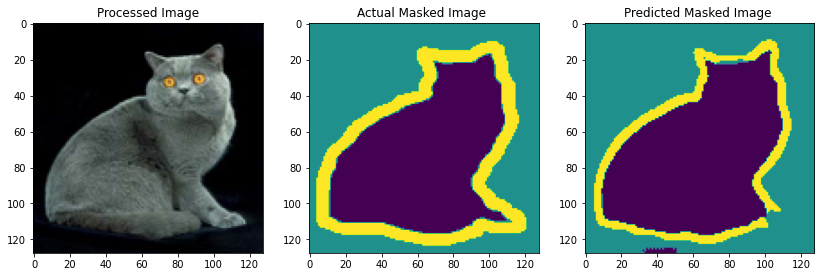

In [ ]:
index = 120
VisualizeResults(index)

<a name='5.3'></a>
## 5.3 - Some Techniques to Improve Results

add some ideas from coursera notes, give credit